In [359]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import pipeline
from sklearn import preprocessing
import time
from sklearn import impute
from sklearn import compose
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree          import DecisionTreeRegressor
from sklearn.ensemble      import RandomForestRegressor
from sklearn.ensemble      import ExtraTreesRegressor
from sklearn.ensemble      import AdaBoostRegressor
from sklearn.ensemble      import GradientBoostingRegressor
from xgboost               import XGBRegressor
from lightgbm              import LGBMRegressor
from catboost              import CatBoostRegressor

In [360]:
def get_dataframe(path):
    df = pd.read_csv(path)
    # Splitting the timestamp column into 3 columns namely years, months and hours
    df['year'] = df['timestamp'].apply(lambda row: row[:4])
    df['month'] = df['timestamp'].apply(lambda row: row.split('-')[1])
    df['hour'] = df['timestamp'].apply(lambda row: row.split(':')[0][-2:])
    df.drop('timestamp', axis=1, inplace=True)
    return df

In [361]:
# Creating a new dataframe df_bike
df_bike = get_dataframe("./data/london_merged.csv")

In [362]:
# Splitting features and the target variables from the dataset
X = df_bike.iloc[:,1:]
y = df_bike.iloc[:,0]

In [371]:
X

,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,hour
0,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,01,00
1,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,01,01
2,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,01,02
3,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,01,03
4,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,01,04
...,...,...,...,...,...,...,...,...,...,...,...
17409,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,2017,01,19
17410,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,2017,01,20
17411,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,2017,01,21
17412,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0,2017,01,22


In [363]:
def data_enhancement(data, value):
    gen_data = data
    for season in data['season'].unique():
        seasonal_data =  gen_data[gen_data['season'] == season]
        hum_std = seasonal_data['hum'].std()
        wind_speed_std = seasonal_data['wind_speed'].std()
        t1_std = seasonal_data['t1'].std()
        t2_std = seasonal_data['t2'].std()
        for i in gen_data[gen_data['season'] == season].index:
            if np.random.randint(2) == 1:
                gen_data['hum'].values[i] += hum_std/10
            else:
                gen_data['hum'].values[i] -= hum_std/10
            if np.random.randint(2) == 1:
                gen_data['wind_speed'].values[i] += wind_speed_std/10
            else:
                gen_data['wind_speed'].values[i] -= wind_speed_std/10
            if np.random.randint(2) == 1:
                gen_data['t1'].values[i] += t1_std/10
            else:
                gen_data['t1'].values[i] -= t1_std/10
            if np.random.randint(2) == 1:
                gen_data['t2'].values[i] += t2_std/10
            else:
                gen_data['t2'].values[i] -= t2_std/10
                
        samples = gen_data.sample(gen_data.shape[0] // value)
        return samples

In [390]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)  # Recommended for reproducibility
extra_sample = data_enhancement(df_bike, 4)
x_train = pd.concat([x_train, extra_sample.drop(['cnt'], axis=1)])
y_train = pd.concat([y_train, extra_sample['cnt']])
transformer = preprocessing.MinMaxScaler()
y_train = transformer.fit_transform(y_train.values.reshape(-1, 1))
y_test = transformer.transform(y_test.values.reshape(-1, 1))

In [382]:
X_train

,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,hour
4493,26.0,25.0,25.0,18.0,1.0,0.0,0.0,1.0,2015,07,16
14407,16.5,16.5,66.0,5.0,1.0,0.0,0.0,1.0,2016,08,02
7862,11.0,11.0,72.0,27.0,7.0,0.0,1.0,2.0,2015,11,06
2627,11.5,11.5,69.5,17.0,1.0,0.0,0.0,0.0,2015,04,19
1764,9.0,6.0,66.0,18.0,2.0,0.0,0.0,0.0,2015,03,14
...,...,...,...,...,...,...,...,...,...,...,...
9225,11.5,11.5,72.0,14.0,1.0,0.0,0.0,3.0,2016,01,06
13123,16.0,16.0,68.0,13.0,2.0,0.0,0.0,1.0,2016,07,07
9845,11.5,11.5,65.0,30.0,2.0,0.0,1.0,3.0,2016,02,10
10799,10.0,8.0,62.0,19.0,2.0,0.0,0.0,0.0,2016,03,19


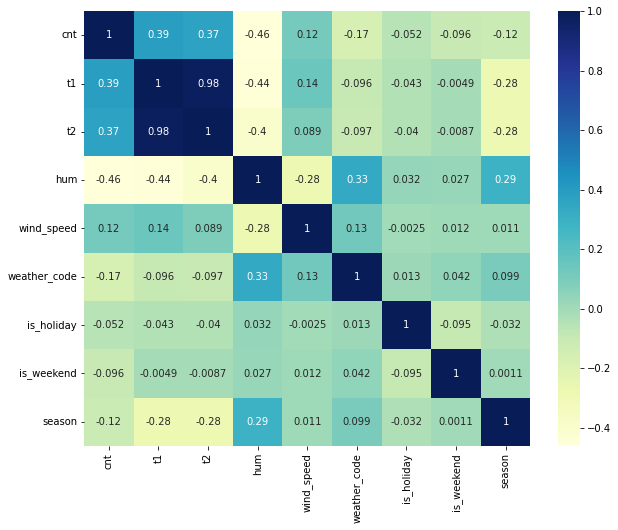

In [391]:
# Checking the correlation of each features in the given dataset
correlation = df_bike.corr()
corr_features = correlation.index
plt.figure(figsize=(10,8))
fig = sns.heatmap(df_bike[corr_features].corr(), annot=True, cmap="YlGnBu")

In [394]:
# Feature Selection using SelectKBest
X_new = SelectKBest(f_regression, k=6).fit_transform(x_train, y_train.flatten())

In [395]:
X_new

array([[26.0, 25.0, 25.0, 18.0, 1.0, '16'],
       [16.5, 16.5, 66.0, 5.0, 1.0, '02'],
       [11.0, 11.0, 72.0, 27.0, 7.0, '06'],
       ...,
       [8.0, 5.5, 82.0, 16.5, 2.0, '20'],
       [11.0, 11.0, 72.0, 28.0, 2.0, '01'],
       [8.0, 5.0, 71.0, 16.0, 4.0, '02']], dtype=object)

In [386]:
cat_vars = ['hour','weather_code']
num_vars = ['t1','t2','hum','wind_speed']
    
num_4_treeModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value=-9999)),
])
cat_4_treeModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', preprocessing.OrdinalEncoder()) # handle_unknown='ignore' ONLY IN VERSION 0.24
])
tree_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_4_treeModels, num_vars),
    ('cat', cat_4_treeModels, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

In [387]:
def get_scores(model, train_x, train_y, test, predict):
    results = []
    for name, model in model.items():
        start_time = time.time()
        model.fit(train_x, train_y.ravel())
        total_time = time.time() - start_time
        prediction = model.predict(test)
        results.append({
            'ModelName': name,
            'MSE': metrics.mean_squared_error(prediction, predict),
            'MAE': metrics.mean_absolute_error(prediction, predict),
            'Time': total_time})
    return pd.DataFrame(results)

In [388]:
tree_classifiers = {
  "Decision Tree": DecisionTreeRegressor(),
  "Extra Trees":   ExtraTreesRegressor(n_estimators=100),
  "Random Forest": RandomForestRegressor(n_estimators=100),
  "AdaBoost":      AdaBoostRegressor(n_estimators=100),
  "Skl GBM":       GradientBoostingRegressor(n_estimators=100),
  "XGBoost":       XGBRegressor(n_estimators=100),
  "LightGBM":      LGBMRegressor(n_estimators=100),
  "CatBoost":      CatBoostRegressor(n_estimators=100),
}

tree_classifiers = {name: pipeline.make_pipeline(tree_prepro, model) for name, model in tree_classifiers.items()}

get_scores(tree_classifiers, x_train, y_train, x_test, y_test)

Learning rate set to 0.421295
0:	learn: 0.7893204	total: 3.21ms	remaining: 318ms
1:	learn: 0.6694658	total: 6.24ms	remaining: 306ms
2:	learn: 0.5951260	total: 9.6ms	remaining: 311ms
3:	learn: 0.5641570	total: 12.6ms	remaining: 302ms
4:	learn: 0.5406639	total: 15.6ms	remaining: 296ms
5:	learn: 0.5290777	total: 19.1ms	remaining: 300ms
6:	learn: 0.5247465	total: 22.1ms	remaining: 294ms
7:	learn: 0.5206720	total: 25.2ms	remaining: 290ms
8:	learn: 0.5175714	total: 28ms	remaining: 284ms
9:	learn: 0.5160368	total: 30.9ms	remaining: 278ms
10:	learn: 0.5143852	total: 33.8ms	remaining: 273ms
11:	learn: 0.5131739	total: 36.5ms	remaining: 268ms
12:	learn: 0.5116473	total: 39.5ms	remaining: 264ms
13:	learn: 0.5108298	total: 42.3ms	remaining: 260ms
14:	learn: 0.5101084	total: 45.3ms	remaining: 257ms
15:	learn: 0.5094184	total: 48.2ms	remaining: 253ms
16:	learn: 0.5068525	total: 51.3ms	remaining: 250ms
17:	learn: 0.5057862	total: 54.4ms	remaining: 248ms
18:	learn: 0.5042099	total: 57.3ms	remaining: 2

,ModelName,MSE,MAE,Time
0,Decision Tree,0.412995,0.318165,0.085770
1,Extra Trees,0.243218,0.260114,2.674194
2,Random Forest,0.239632,0.280332,4.202191
3,AdaBoost,0.521703,0.551070,0.376991
4,Skl GBM,0.267619,0.329431,1.127090
5,XGBoost,0.251325,0.310376,0.679292
6,LightGBM,0.251112,0.307721,0.215426
7,CatBoost,0.252180,0.311509,1.789526


In [389]:
y.unique()

array([ 182,  138,  134, ..., 2842,   10, 2220], dtype=int64)

In [400]:
for season in df_bike['season'].unique():
        seasonal_data =  df_bike[df_bike['season'] == season]

In [401]:
seasonal_data

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,hour
5745,235,15.0,15.0,88.0,10.0,4.0,0.0,0.0,2.0,2015,09,00
5746,156,15.0,15.0,88.0,11.0,3.0,0.0,0.0,2.0,2015,09,01
5747,127,15.0,15.0,85.0,12.0,3.0,0.0,0.0,2.0,2015,09,02
5748,62,15.0,15.0,85.0,10.0,3.0,0.0,0.0,2.0,2015,09,03
5749,79,15.0,15.0,88.0,8.0,7.0,0.0,0.0,2.0,2015,09,04
...,...,...,...,...,...,...,...,...,...,...,...,...
16593,1560,4.5,1.5,63.0,13.0,1.0,0.0,0.0,2.0,2016,11,19
16594,969,4.0,1.0,63.0,13.0,1.0,0.0,0.0,2.0,2016,11,20
16595,657,4.0,1.0,63.0,13.0,1.0,0.0,0.0,2.0,2016,11,21
16596,597,3.0,-0.5,60.0,14.0,1.0,0.0,0.0,2.0,2016,11,22


In [402]:
hum_std = seasonal_data['hum'].std()